# Notebook for analysis data generated from the Segway

Text(0.5,0,'T [s]')

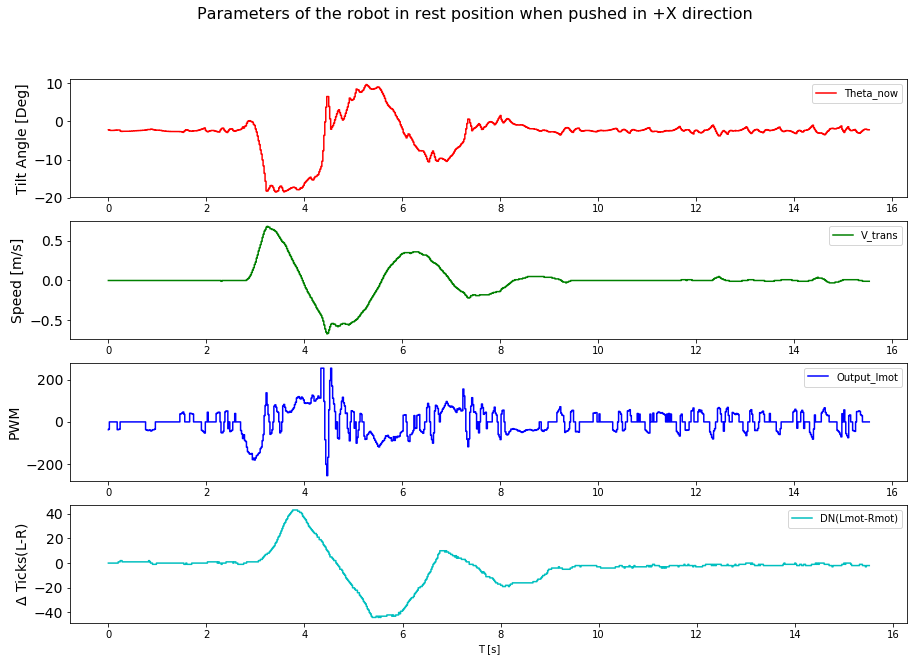

In [20]:
%matplotlib inline
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt

df1 = pd.read_csv("Set_3.txt")

df1["DN(Lmot-Rmot)"] = df1["DN_Lmot"] - df1["DN_Rmot"]

#cols2plot = df1.columns

cols2plot = ['Theta_now','V_trans','Output_lmot','DN(Lmot-Rmot)']
units = ["Tilt Angle [Deg]", "Speed [m/s]", "PWM", "$\Delta$ Ticks(L-R)", "Ticks", "Ticks"]

clr = ['r','g','b','c','b','g', 'r', 'k', 'm']

dt = 0.02 # Sampling time [s]

t = [i*dt for i in range(len(df1)) ]
k1 = 0; k2 = len(df1);

plt.close("all")
plt.figure(figsize = (15,10))
plt.suptitle("Parameters of the robot in rest position when pushed in +X direction", fontsize = 16)

for i,col, unit in zip(range(len(cols2plot)), cols2plot, units):
    plt.subplot(len(cols2plot),1,i+1)
    plt.step(t[k1:k2], df1.loc[k1:k2, col], clr[i], label = col)
    plt.legend(loc = "upper right")
    plt.ylabel(unit, fontsize = 14)
    plt.yticks(fontsize = 14)

plt.xlabel("T [s]")

#a = df1["V_trans"]
#y = np.fft.fft(a) # Getting complex coefficients of the data points in frequency domain
#
#C = np.fft.fftfreq(len(t),dt)# Getting the frequency bins [Hz]
#
#plt.figure()
#plt.subplot(211)
#plt.plot(t,a, label = 'Horizontal direction')
#plt.subplot(212)
#plt.plot(C[C>0],abs(y[C>0])/(0.5*len(y)))
#plt.xlim(0,2)
#plt.xlabel("Frequency [Hz]")
#plt.ylabel("Amplitude [mm/s]")
